# Technical Indicators

### An aggregate of technicals indicators which passes for predictors.
### The best predictors are used in the deployment algo for making the 
### required prediction on strategy returns.


In [11]:
import pandas as pd
import numpy as np

class TechnicalIndicators:
    
    def moving_average(df, n):
        """Calculate the moving average for the given data.
        :param df: pandas.DataFrame
        :param n: window
        :return: pandas.DataFrame
        """
        MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_{}'.format(n))
        
        return MA
    
    
    def exponential_moving_average(df, n):
        """
        :param df: pandas.DataFrame
        :param n: window of data to take moving exponent mean
        :return: pandas.DataFrame
        """
        EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
        return EMA
    
    def commodity_channel_index(df, n):
        """Calculate Commodity Channel Index for given data.
        :param df: pandas.DataFrame
        :param n: data window
        :return: pandas.DataFrame
        """
        PP = (df['High'] + df['Low'] + df['Close']) / 3
        CCI = pd.Series((PP - PP.rolling(n, min_periods=n).mean()) / PP.rolling(n, min_periods=n).std(),
                        name='CCI_' + str(n))
        return CCI
    
    def momentum(df, n):
        """
        :param df: pandas.DataFrame 
        :param n: data window
        :return: pandas.DataFrame
        """
        M = pd.Series(df['Close'].diff(n), name='Momentum_' + str(n))
        return M
    
    def stochastic_oscillator_k(df):
        """Calculate stochastic oscillator %K for given data.
        :param df: pandas.DataFrame
        :return: pandas.DataFrame
        """
        SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
        return SOk
    
    
    def stochastic_oscillator_d(df, n):
        """Calculate stochastic oscillator %D for given data.
        :param df: pandas.DataFrame
        :param n: data window
        :return: pandas.DataFrame
        """
        SOk = pd.Series((df['Close'] - df['Low']) / (df['High'] - df['Low']), name='SO%k')
        SOd = pd.Series(SOk.ewm(span=n, min_periods=n).mean(), name='SO%d_' + str(n))
        return SOd
    
    def mass_index(df, n):
        """Calculate the Mass Index for given data.
        
        :param df: pandas.DataFrame
        :return: pandas.DataFrame
        """
        Range = df['High'] - df['Low']
        EX1 = Range.ewm(span=9, min_periods=9).mean()
        EX2 = EX1.ewm(span=9, min_periods=9).mean()
        Mass = EX1 / EX2
        MassI = pd.Series(Mass.rolling(n).sum(), name='Mass Index')
        return MassI
    
    def force_index(df, n):
        """Calculate Force Index for given data.
        
        :param df: pandas.DataFrame
        :param n: data window
        :return: pandas.DataFrame
        """
        F = pd.Series(df['Close'].diff(n) * df['Volume'].diff(n), name='Force_' + str(n))
        return F


# Stock Returns Using different Predicitive Models in Machine Learning

#### This notebook is a follow up of my script files. 
#### The script is divided into different classes to avoid misunderstanding my approach.
##### Begining with the first class
---------------------------------------------------------------------------------------------
###### FetchData: Fetches the stock data using YAHOO API provided by pandas
---------------------------------------------------------------------------------------------
###### Predictors: Extract the predictors from the TECHNICAL INDICATOR CLASS
###### Note that you can add as many predictors as desired. Avoid using excess
###### predictors because some are highly correlated and would only reduce the test accuracy.
---------------------------------------------------------------------------------------------
#### NormalizeData: this is a neccesary step to avoid giving importance to one feature vector
#### over the other. Data normalization is a common use case in predictive modeling.
#### the goal is required for the algorithms to model the data correctly.
-----------------------------------------------------------------------------------------
#### feature_importance: To be able to understand the feature vectors that make the most impact on our data
#### feature importance plot is necessary. However i have not applied the result of the importance here.
#### A common used case here would be to sellect only the feature >0.8 as our final predictors.

In [12]:
import pandas as pd
import numpy as np
from pandas_datareader import data as dr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
#from TechnicalIndicators import TechnicalIndicators
from datetime import datetime
import yfinance as yfin

def FetchData(data,source,start,end):
    if not data:
        raise ValueError('Stock name not available')
    elif not start or not end:
        raise ValueError('Start date and End date not specified')
    else:
      yfin.pdr_override()
      dataframe = dr.get_data_yahoo(data, start=start, end=end)
    return dataframe
       
dataframe = FetchData("TSLA", "yahoo", '2010-01-01','2022-12-01')

class Predictors:
    def __init__(self, data):
        '''
        Contains a list of technical indicators.
        This indicators are what we put together
        For this project we would focus on the  following Indicators
            --Exponential Moving Average --> For predicting Trend
            --Commodity Channel Index --> Forecasting the future price move
            --Momentum --> The rate of change of price especially clossing
            --Stochastic Oscillator --> Future price movement
            --Mass Index -->Average Exponential Index
            --Force -->Relative Strength Index
        '''
        self.dataframe = data
        return self.predictors()
    
    def predictors(self):

      self.dataframe['MA'] = TechnicalIndicators.moving_average(self.dataframe, 10)
      self.dataframe['EMA'] = TechnicalIndicators.exponential_moving_average(self.dataframe, 10)
      self.dataframe['CCI'] = TechnicalIndicators.commodity_channel_index(self.dataframe, 10)
      self.dataframe['MMT'] = TechnicalIndicators.momentum(self.dataframe, 10)
      self.dataframe['SOD'] = TechnicalIndicators.stochastic_oscillator_d(self.dataframe, 10)
      self.dataframe['SOK'] = TechnicalIndicators.stochastic_oscillator_k(self.dataframe)
      self.dataframe['FI'] = TechnicalIndicators.force_index(self.dataframe, 10)
      self.dataframe['MI'] = TechnicalIndicators.mass_index(self.dataframe, 10)
      return self.dataframe.fillna(0, inplace=True)
        

class NormalizeData(object):
    def __init__(self,data, short_price, long_price):
        
        '''
        :short_price: 
                    MA short and Long
        :long_price:
                    MA Long and Short
        '''
        self.short_price = short_price
        self.long_price = long_price
        self.data = data
        
    def normalizeData(self):

      Xf = pd.DataFrame(MinMaxScaler().fit_transform(self.data.drop(['Close'], axis = 1).values))
      Xf.columns = dataframe.columns.drop(['Close'])
      if not self.long_price > self.short_price:
        raise ValueError('Short price should be less than long')
      elif self.short_price == self.long_price:
        raise ValueError('Prices should not be the same')
      else:
        '''
        The Yf states:
        When short_price is greater than Long_price--> Buy
        When short_price is less than long_price --> Sell
        '''
        Yf = np.where(self.data['Close'].rolling(window = self.short_price).mean() > self.data['Close'].rolling(window = self.long_price).mean(),1,0)
        #Train/Test Split
      X_train, X_test, Y_train, Y_test = train_test_split(Xf, Yf, test_size = 0.3, random_state = False)
      return Xf, Yf, X_train, X_test, Y_train, Y_test
        


class feature_importance(object):
    def __init__(self, Xf, Yf):
        import matplotlib.pyplot as plt
        import seaborn as sns
        from sklearn.ensemble import RandomForestClassifier
        self.model = RandomForestClassifier(n_estimators=250, max_depth=25)
        self.model.fit(Xf, Yf)
        importance = pd.DataFrame({'features': Xf.columns,
                        'importances': self.model.feature_importances_})
        importance = importance.sort_values('importances', ascending=False)
        plt.figure(figsize = (16,12))
        sns.barplot(x=importance.importances, y=importance.features,alpha=0.8)
        plt.title('Feature Importance Plot')
        plt.show()

[*********************100%***********************]  1 of 1 completed


# Predictive Models

In [14]:
import pandas as pd
import numpy as np
import graphviz 
from datetime import datetime
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
#from TechnicalIndicators import TechnicalIndicators
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_validate
from xgboost.sklearn import XGBClassifier

class Model():
    
    def __init__(self):
        '''
        Define the Classifiers to be Used for 
        @Classifiers:
                    List of Tuples
        @Pipeline: Channel of Estimators
        @Employ the use of GridSearchCV
        Predicting Returns
        '''
        self.KERNELS = ['linear', 'rbf']
        self.GAMMA = [0.0001, 0.001, 0.01, 1]
        self.CRITERION = ['gini', 'entropy']
        self.RANGE = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        self.N_VALIDATION = 2
        self.BEST_ACCURACY = 0.0
        self.BEST_GRIDSEARCH = ''
        self.BEST_CLASSIFIER = 0
        
        self.pipe_SVC = Pipeline([('normalizer', StandardScaler()), ('clf', SVC())])

        self.pipe_LogisticRegression = Pipeline([('normalizer', StandardScaler()), ('clf', LogisticRegression())])
        self.pipe_DecisionTreeClassifier = Pipeline([('normalizer', StandardScaler()), ('clf', DecisionTreeClassifier())])
    
        self.pipe_RandomForestClassifier = Pipeline([('normalizer', StandardScaler()), ('clf', RandomForestClassifier())])
        
        self.pipe_SVC_params = [{'clf__kernel': self.KERNELS,
                                'clf__C': self.RANGE,
                                'clf__gamma': self.GAMMA}]
        
        self.pipe_RandomForestClassifier_params = [{'clf__criterion': self.CRITERION,
                                                     'clf__max_depth': np.arange(2,10),
                                                     'clf__min_samples_split': np.arange(2,10),
                                                     'clf__min_samples_leaf': np.arange(2,10),
                                                     'clf__n_estimators': np.arange(1,2)}]
        self.pipe_DecisionTreeClassifier_param = [{'clf__max_depth': np.arange(2,10),
                                                    }]
        self.pipe_LogisticRegression_params = [{'clf__penalty': ['l1', 'l2'],
                                        		'clf__C': [1.0, 0.5, 0.1], 'clf__solver': ['liblinear']}]
        
        
    def optimize(self, X_train, X_test, Y_train, Y_test):
        '''
        Here we call the GridSearchCV class to get
        the best parameters or better still optimized parameters
        for our data.
        Remember the Gridsearch is done througk the pipeline.
        '''
        
        self.grid_RandomForestClassifier = GridSearchCV(estimator = self.pipe_RandomForestClassifier, 
                                                        param_grid = self.pipe_RandomForestClassifier_params,
                                                        scoring='accuracy',	cv = self.N_VALIDATION)

        self.grid_SVC = GridSearchCV(estimator = self.pipe_SVC, param_grid = self.pipe_SVC_params,
                                             scoring='accuracy',	cv = self.N_VALIDATION)
        
        self.grid_LogisticRegression = GridSearchCV(estimator = self.pipe_LogisticRegression, 
                                                    param_grid = self.pipe_LogisticRegression_params,
                                                    scoring='accuracy',	cv = self.N_VALIDATION)
        
        self.grid_DecisionTreeClassifier = GridSearchCV(estimator = self.pipe_DecisionTreeClassifier,
                                                        param_grid = self.pipe_DecisionTreeClassifier_param,
                                                        scoring='accuracy',	cv = self.N_VALIDATION)
        self.All_grids = {'grid_RandomForestClassifier': self.grid_RandomForestClassifier,
                          'grid_SVC': self.grid_SVC, 
                          'grid_LogisticRegression': self.grid_LogisticRegression,
                          'grid_DecisionTreeClassifier': self.grid_DecisionTreeClassifier,
                          }
        
        print('--------------------------------------------------------')
        print('\tPerforming optimization...')
        for classifier_grid_name, classifier_grid in self.All_grids.items():
            print('--------------------------------------------------------')
            print('Classifier: {}'.format(classifier_grid_name))	
        	# Fit grid search	
            classifier_grid.fit(X_train, Y_train)
        	# Best params
            print('Best params: {}'.format(classifier_grid.best_params_))
        	# Best training data accuracy
            print('Best training accuracy: {}'.format(classifier_grid.best_score_))
        	# Predict on test data with best params
            Y_Prediction = classifier_grid.predict(X_test)
        	# Test data accuracy of model with best params
            print('Test set accuracy score for best params: {}'.format(accuracy_score(Y_test, Y_Prediction)))
            print('--------------------------------------------------------')
        	# Track best (highest test accuracy) model
            if accuracy_score(Y_test, Y_Prediction) > self.BEST_ACCURACY:
                self.BEST_ACCURACY = accuracy_score(Y_test, Y_Prediction)
                self.BEST_GRIDSEARCH = classifier_grid
                self.BEST_CLASSIFIER = classifier_grid_name
        print('\nClassifier with best test set accuracy: {}'.format(self.BEST_CLASSIFIER))
        
        return self.BEST_GRIDSEARCH
            

# Feature Engineering Search and Performance 

## The following cell outputs the best features in descending order. 
#### Performance of the various classifiers.
#### Chooses the best classifier for prediction
#### Output strategy returns together with stock returns.

#### based on this we can select the stock with the best strategy result
#### and trade this stock. since the return would be high compared to other stocks.

### Also note that the performance of the algorithm is based on your strategy. tweaking the strategy
### would give different result at different times and this would impact the accuracy score of the test data.


[*********************100%***********************]  1 of 1 completed


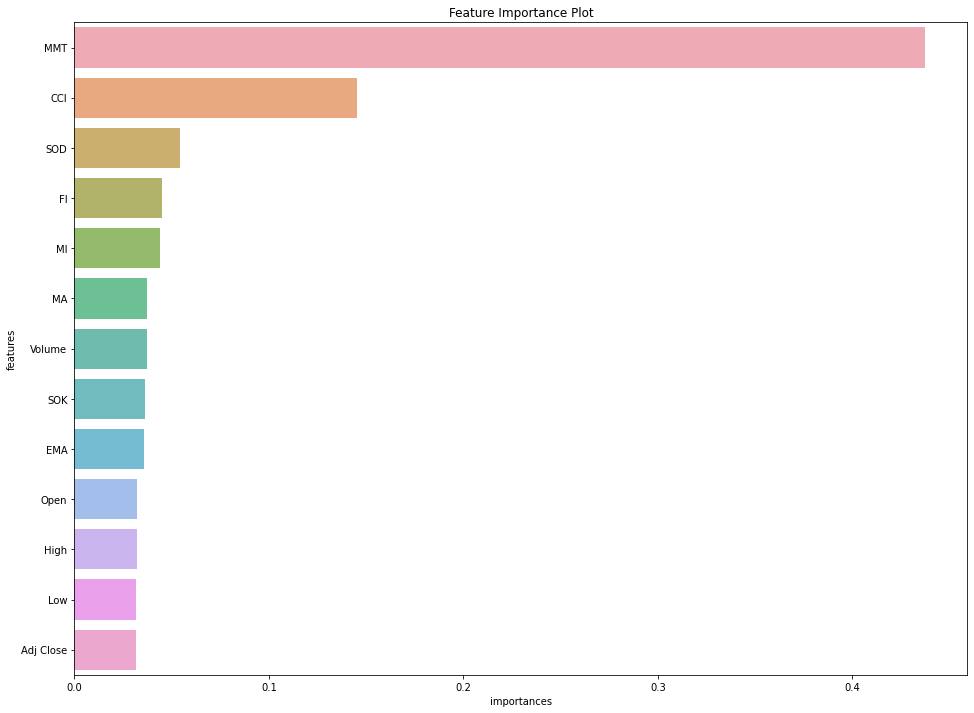

--------------------------------------------------------
	Performing optimization...
--------------------------------------------------------
Classifier: grid_RandomForestClassifier
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 2, 'clf__min_samples_leaf': 8, 'clf__min_samples_split': 3, 'clf__n_estimators': 1}
Best training accuracy: 0.8662597114317425
Test set accuracy score for best params: 0.7257438551099612
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_SVC
Best params: {'clf__C': 10, 'clf__gamma': 0.0001, 'clf__kernel': 'linear'}
Best training accuracy: 0.8013318534961154
Test set accuracy score for best params: 0.7930142302716688
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_LogisticRegression
Best params: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.79

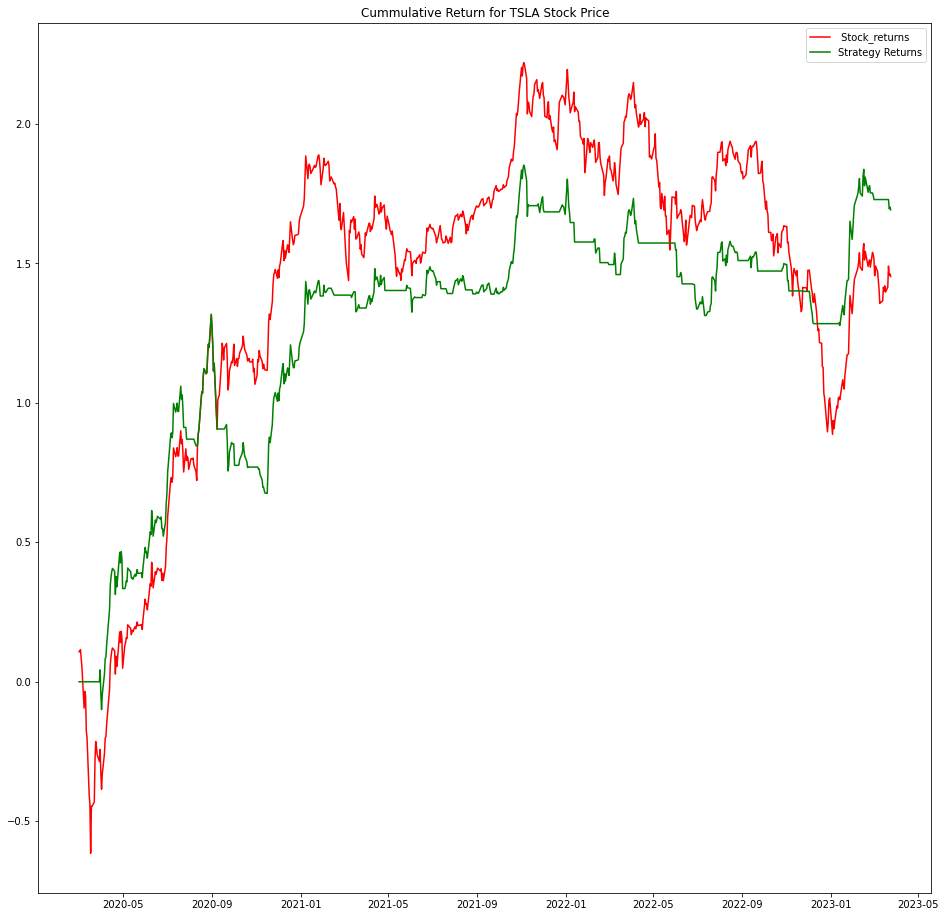

[*********************100%***********************]  1 of 1 completed


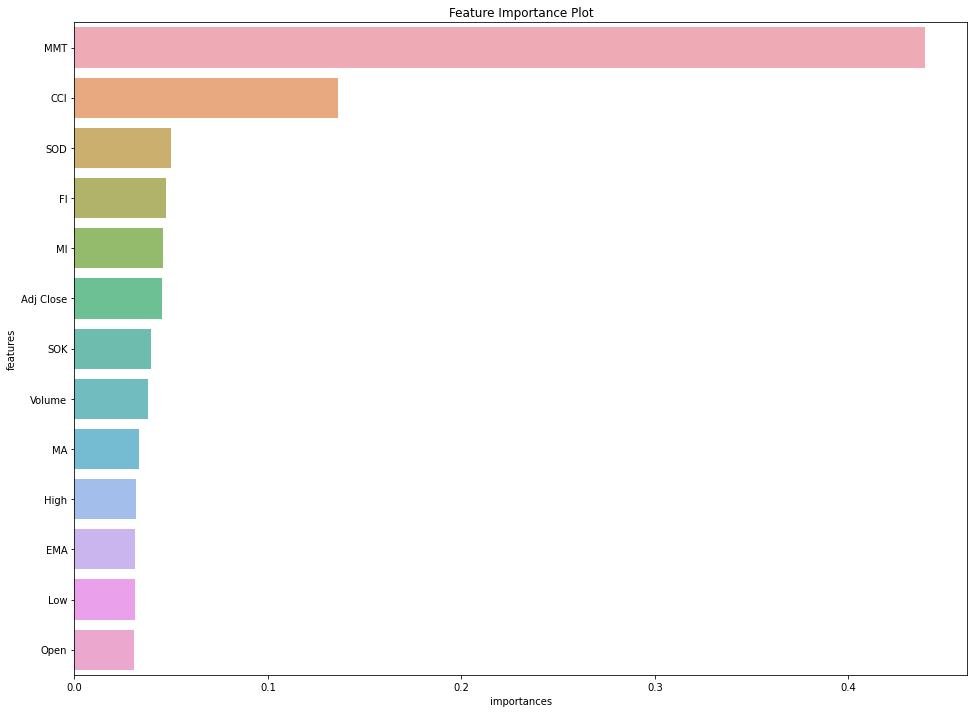

--------------------------------------------------------
	Performing optimization...
--------------------------------------------------------
Classifier: grid_RandomForestClassifier
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 8, 'clf__n_estimators': 1}
Best training accuracy: 0.8523862375138735
Test set accuracy score for best params: 0.7373868046571799
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_SVC
Best params: {'clf__C': 10, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}
Best training accuracy: 0.8695893451720311
Test set accuracy score for best params: 0.8706338939197931
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_LogisticRegression
Best params: {'clf__C': 0.5, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy: 0.8662597114

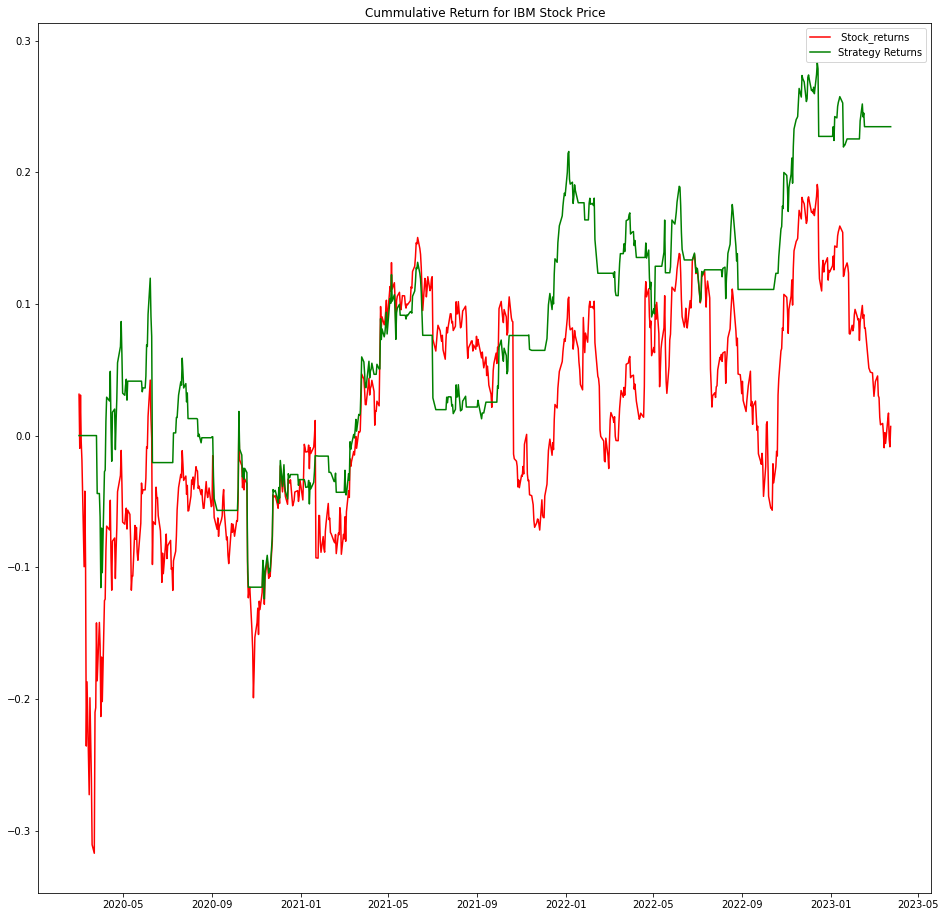

[*********************100%***********************]  1 of 1 completed


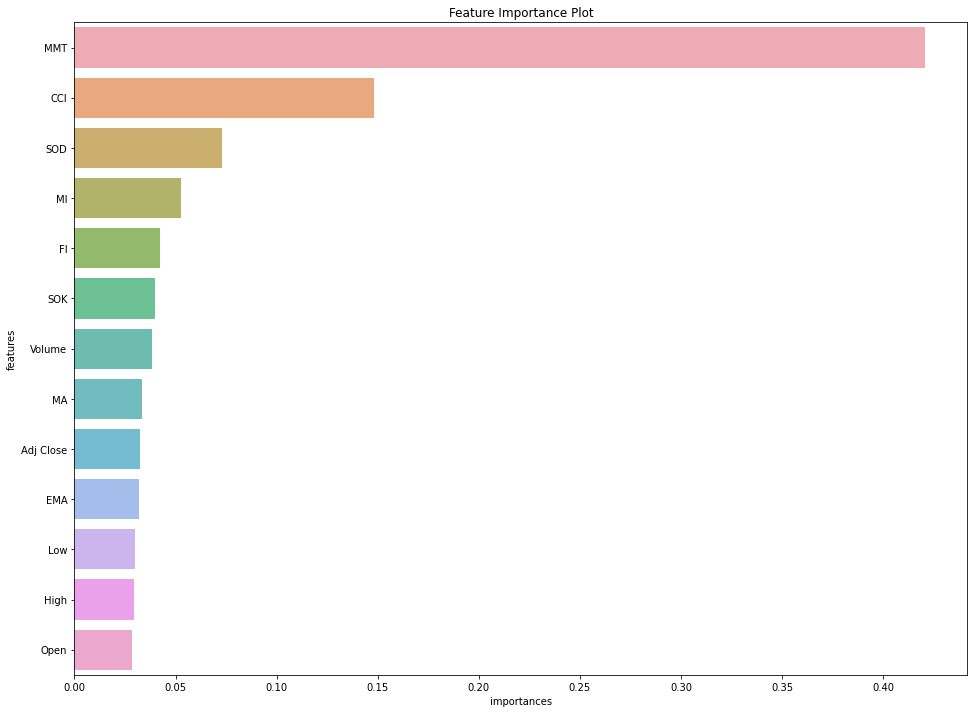

--------------------------------------------------------
	Performing optimization...
--------------------------------------------------------
Classifier: grid_RandomForestClassifier
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 3, 'clf__n_estimators': 1}
Best training accuracy: 0.867369589345172
Test set accuracy score for best params: 0.6041397153945667
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_SVC
Best params: {'clf__C': 10, 'clf__gamma': 0.0001, 'clf__kernel': 'linear'}
Best training accuracy: 0.8640399556048834
Test set accuracy score for best params: 0.8615782664941786
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_LogisticRegression
Best params: {'clf__C': 0.5, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.853496

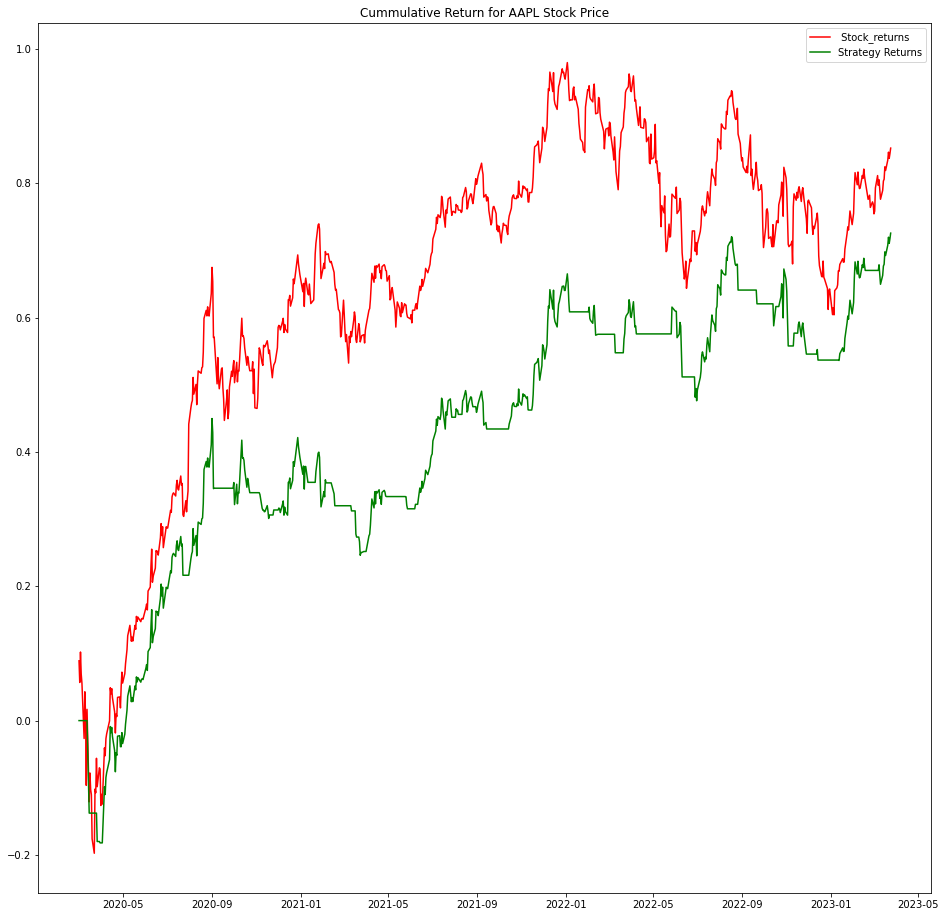

[*********************100%***********************]  1 of 1 completed


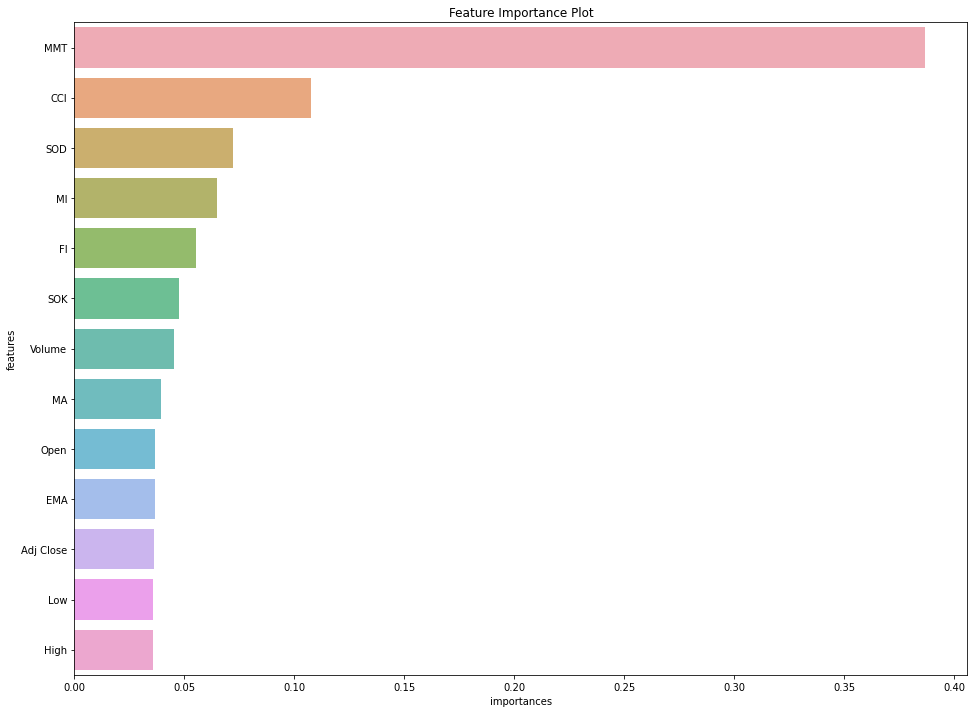

--------------------------------------------------------
	Performing optimization...
--------------------------------------------------------
Classifier: grid_RandomForestClassifier
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 4, 'clf__min_samples_leaf': 7, 'clf__min_samples_split': 9, 'clf__n_estimators': 1}
Best training accuracy: 0.8412874583795782
Test set accuracy score for best params: 0.7839586028460543
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_SVC
Best params: {'clf__C': 9, 'clf__gamma': 0.0001, 'clf__kernel': 'linear'}
Best training accuracy: 0.8468368479467259
Test set accuracy score for best params: 0.8201811125485123
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_LogisticRegression
Best params: {'clf__C': 0.5, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.834

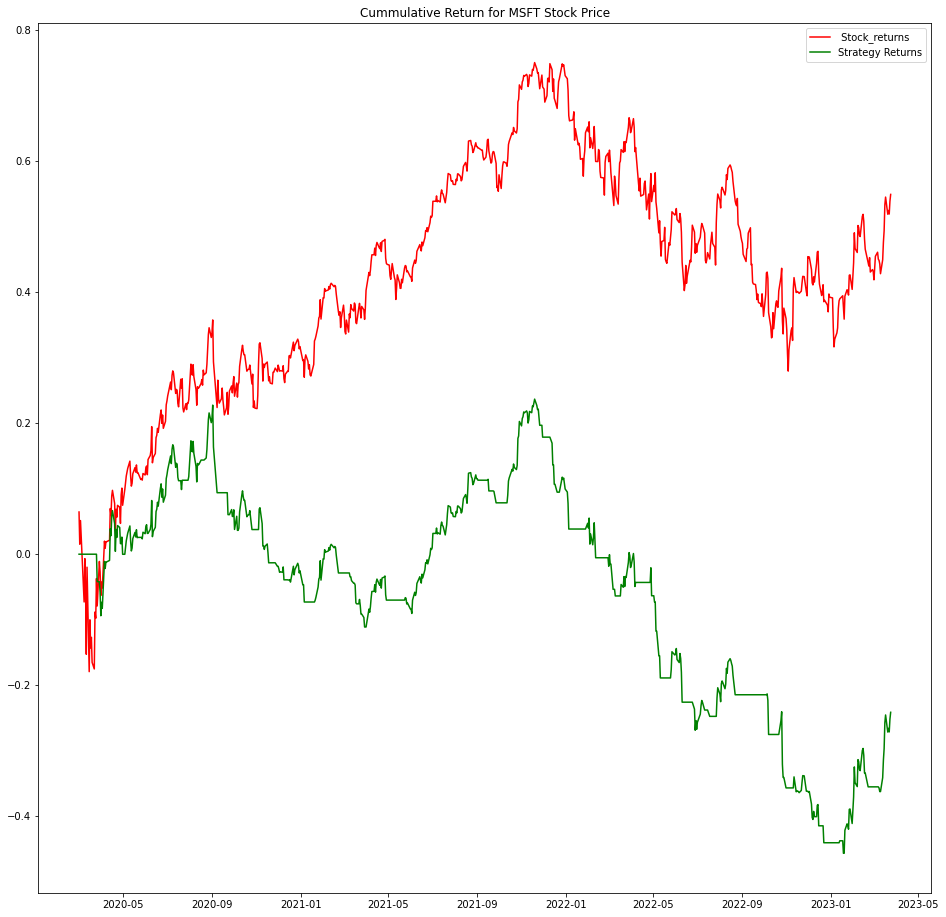

[*********************100%***********************]  1 of 1 completed


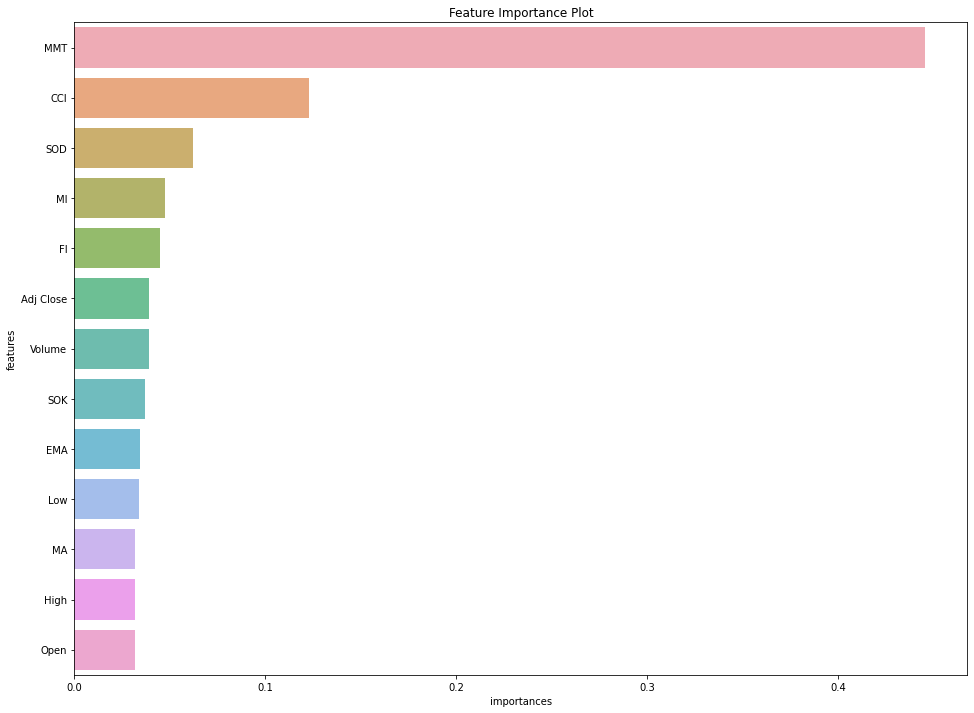

--------------------------------------------------------
	Performing optimization...
--------------------------------------------------------
Classifier: grid_RandomForestClassifier
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 2, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 5, 'clf__n_estimators': 1}
Best training accuracy: 0.8479467258601554
Test set accuracy score for best params: 0.8382923673997412
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_SVC
Best params: {'clf__C': 4, 'clf__gamma': 0.0001, 'clf__kernel': 'linear'}
Best training accuracy: 0.8640399556048834
Test set accuracy score for best params: 0.8771021992238034
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_LogisticRegression
Best params: {'clf__C': 0.5, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy: 0.857

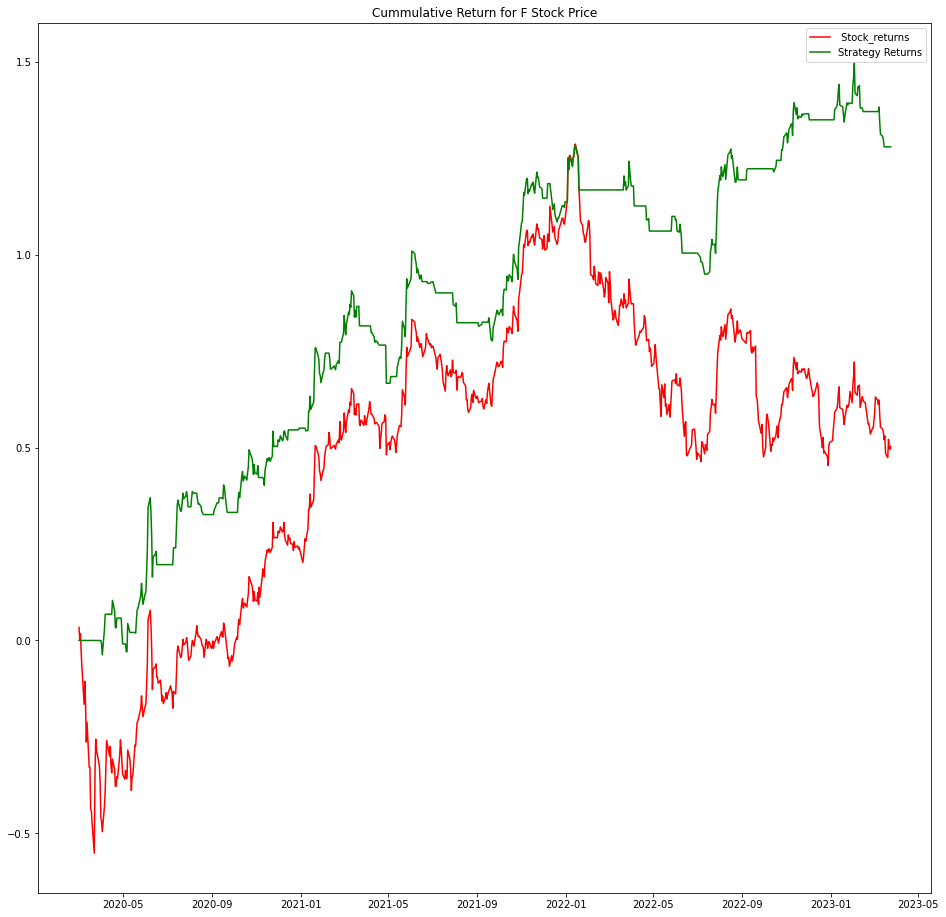

[*********************100%***********************]  1 of 1 completed


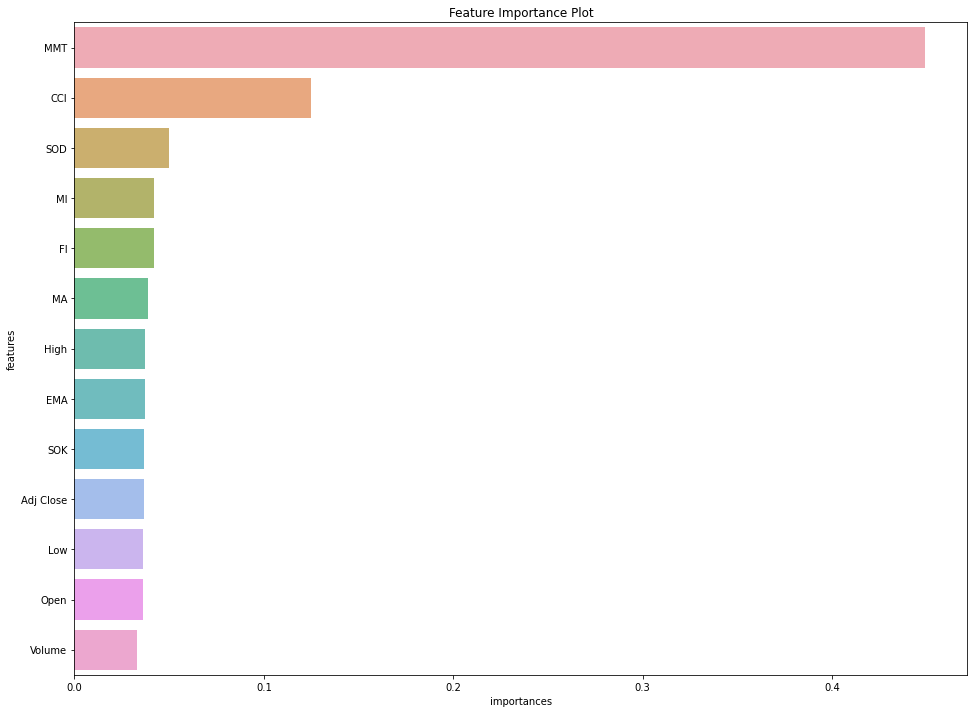

--------------------------------------------------------
	Performing optimization...
--------------------------------------------------------
Classifier: grid_RandomForestClassifier
Best params: {'clf__criterion': 'entropy', 'clf__max_depth': 3, 'clf__min_samples_leaf': 6, 'clf__min_samples_split': 2, 'clf__n_estimators': 1}
Best training accuracy: 0.8568257491675916
Test set accuracy score for best params: 0.8486416558861578
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_SVC
Best params: {'clf__C': 8, 'clf__gamma': 0.0001, 'clf__kernel': 'linear'}
Best training accuracy: 0.8845726970033296
Test set accuracy score for best params: 0.88745148771022
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_LogisticRegression
Best params: {'clf__C': 1.0, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best training accuracy: 0.87347

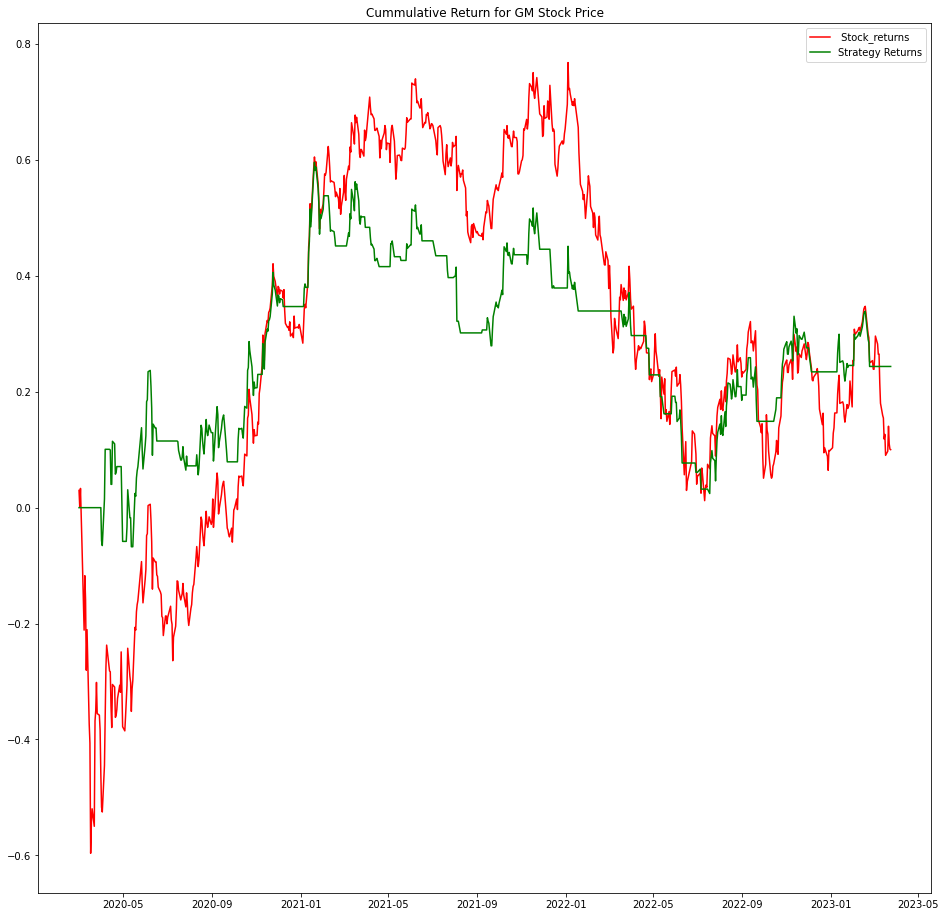

[*********************100%***********************]  1 of 1 completed


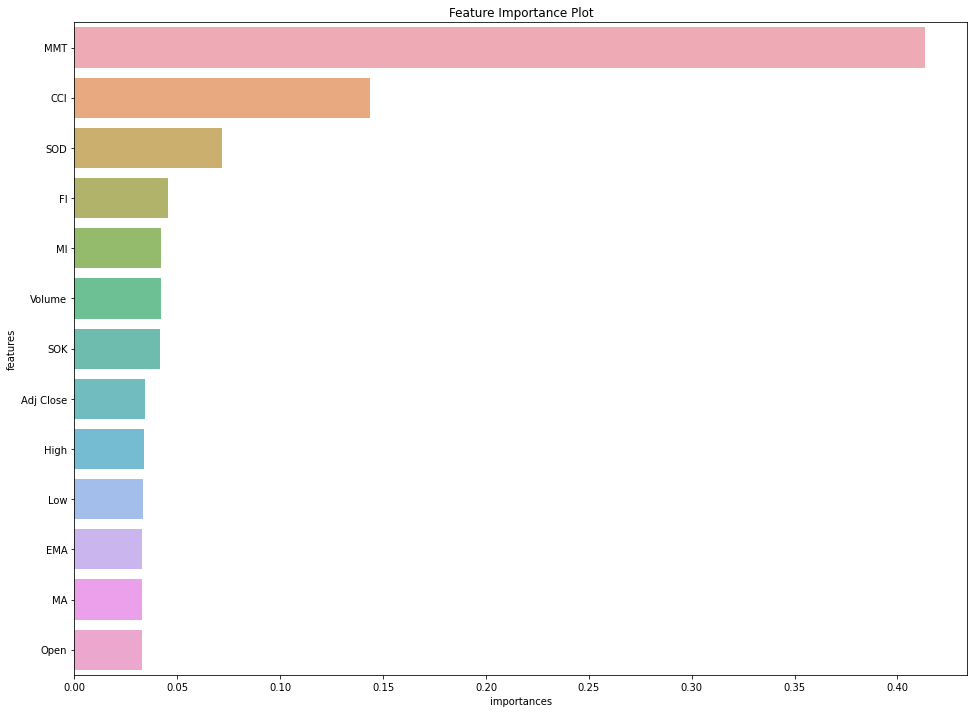

--------------------------------------------------------
	Performing optimization...
--------------------------------------------------------
Classifier: grid_RandomForestClassifier
Best params: {'clf__criterion': 'gini', 'clf__max_depth': 2, 'clf__min_samples_leaf': 7, 'clf__min_samples_split': 7, 'clf__n_estimators': 1}
Best training accuracy: 0.8490566037735849
Test set accuracy score for best params: 0.7865459249676585
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_SVC
Best params: {'clf__C': 10, 'clf__gamma': 0.0001, 'clf__kernel': 'linear'}
Best training accuracy: 0.8768035516093229
Test set accuracy score for best params: 0.888745148771022
--------------------------------------------------------
--------------------------------------------------------
Classifier: grid_LogisticRegression
Best params: {'clf__C': 1.0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Best training accuracy: 0.871809

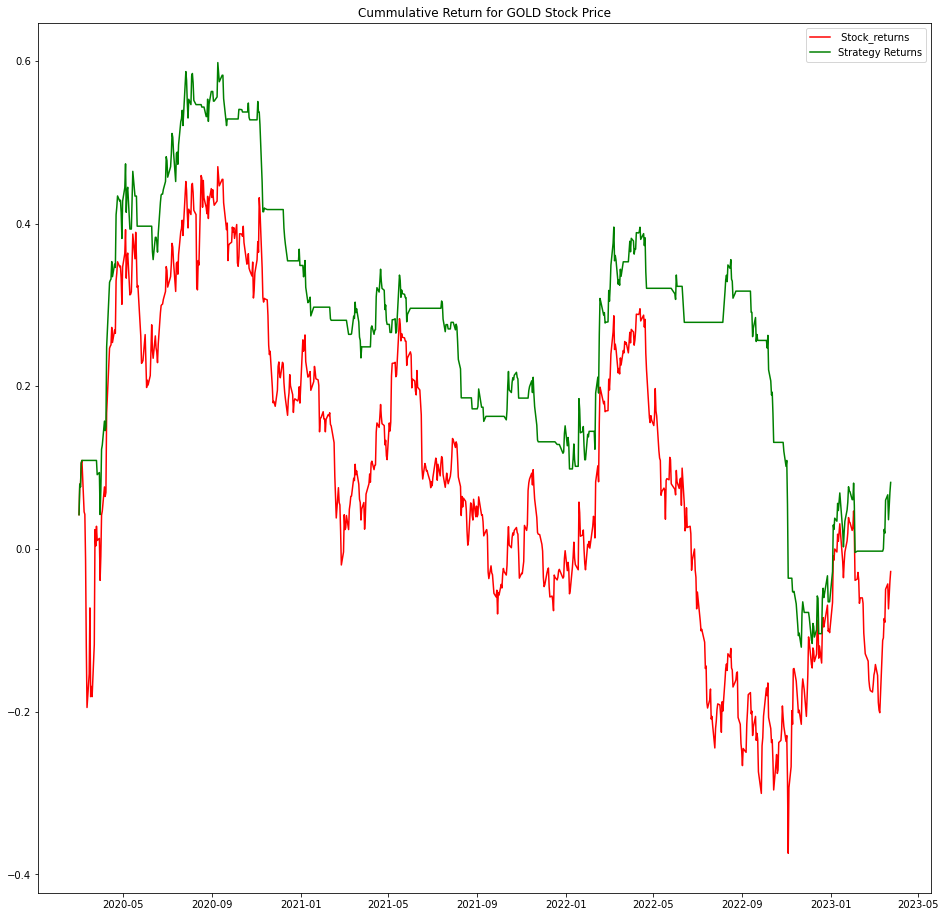

In [10]:

from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

if __name__ == '__main__':
    stock_name = ['TSLA', 'IBM', 'AAPL', 'MSFT', 'F', 'GM', 'GOLD']
    for ii in stock_name:
        dataframe = FetchData(ii, "yahoo", datetime(2013, 1, 1), datetime.now())
        pred = Predictors(dataframe)
        Xf, Yf, X_train, X_test, Y_train, Y_test = NormalizeData(dataframe, 7, 15).normalizeData()
        feature_importance(Xf, Yf)
        split = int(0.7*len(dataframe))
        GSCV = Model().optimize(X_train, X_test, Y_train, Y_test)
        dataframe['Predicted_Signal'] = GSCV.predict(Xf)
        dataframe['Stock_returns'] = np.log(dataframe['Close']/dataframe['Close'].shift(1))
        Cumulative_returns = np.cumsum(dataframe[split:]['Stock_returns'])
        dataframe['Startegy_returns'] = dataframe['Stock_returns']* dataframe['Predicted_Signal'].shift(1)
        Cumulative_Strategy_returns = np.cumsum(dataframe[split:]['Startegy_returns'])
        plt.figure(figsize=(16,16))
        plt.plot(Cumulative_returns, color='r',label = ' Stock_returns')
        plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
        plt.legend()
        plt.title('Cummulative Return for {} Stock Price'.format(ii))
        plt.savefig("D:\\GIT PROJECT\\STOCK-RETURN-PREDICTION-USING-KNN-SVM-GUASSIAN-PROCESS-ADABOOST-TREE-REGRESSION-AND-QDA\\_IMAGES\\Stock{}_2018.png".format(ii))
        plt.show()
        
    
    
